<a href="https://colab.research.google.com/github/keonroohparvar/hpo_algorithms/blob/main/HPO_Algorithms_Keon_Roohparvar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 497/498 - Senior Research Project
*By: Keon Roohparvar*

This Colab notebook contains the implementation of the following three algorithms for Hyperparameter Optimization:

* Random Search Optimization
* Grid Search Optimization
* Bayesian Optimization

The Colab Notebook is organized into the following five portions: 
1. Setup - Contains logic that sets the baseline for all of our implementations.
2. Random Search Algorithm Implementation
3. Grid Search Algorithm Implementation
4. Bayesian Search Algorithm Implementation
5. Comparison of Algorithms

## Setup

For the setup of this project, we will import the required libraries, acquire the required data, preprocess our data, and create a baseline model that we will compare the performance of with our future models. 

In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing, model_selection

import random
import time
from datetime import timedelta

### Data Acquisition and Preprocessing
To acquire the data and preprocess it, we are using the [Boston Housing Dataset](http://lib.stat.cmu.edu/datasets/boston). We also use a Scikit-learn StandardScaler to z-score normalize all of our data.

In [ ]:
# Import data and format it into DataFrame
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = pd.DataFrame(data=raw_df.values[1::2, 2])
df = pd.DataFrame(data=data)

# Manually update feature names in dataframe
feature_names = np.array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')
df.columns = feature_names

df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [ ]:
# Create Scaler
scaler = preprocessing.StandardScaler()

# Normalize the data using the scaler
df_norm = pd.DataFrame(data=scaler.fit_transform(df))
df_norm

# Save data to values X and Y
X = df_norm
Y = target

# Split into training and testing datasets
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=30)

### Baseline Model
To compare a basic model with our future, optimized models, we will create a basic model with 5 layers.

In [ ]:
# Define Model Architecture
model = Sequential()
model.add(Dense(128, input_shape=(13, ), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile model with loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss="mse") 

In [ ]:
# Run the model on initial hyperparameters and see how it performs
control_hist = model.fit(X, Y, epochs=50, verbose=0)

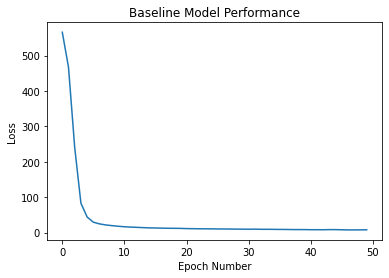

Model Performance: 7.989250183105469


In [ ]:
# Plot the control model's loss
plt.title('Baseline Model Performance')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(range(len(control_hist.history['loss'])), control_hist.history['loss'])
plt.show()
best_loss = control_hist.history['loss'][-1]
print(f'Model Performance: {best_loss}')


## Random Search Optimization
This contains all of the logic for the implementation of the Random Search Optimizer. 

### Define the Hyperspace for Random Search
We need to determine what hyperparameters we have available to us. We are either dealing with discrete hyperparameters, like the loss functions and optimizers, or continuous hyperparameters, like learning rate or number of epochs. In this step, we are defining what are the limits of all the hyperparameters we will be searching for.

For our random search optimizer, we will include limits on the continuous variables, and discrete choices for our discrete variables.

In [ ]:
# Define Hyperspace
opts = ['sgd', 
        'rmsprop', 
        'adam', 
        'adadelta', 
        'adagrad', 
        'adamax', 
        'nadam', 
        'ftrl']

# Not supporting Cosine Similarity & Cross Entropy
loss = ['mse',
        'mae',
        'mape',
        'msle',
        'huber',
        'logcosh'
        ]

# Not supporting Softmax
activations = ['relu',
               'sigmoid',
               'softplus',
               'softsign',
               'tanh',
               'selu',
               'elu',
               'exponential']


num_epochs = {
    'min': 5,
    'max': 1000
}

learning_rate = {
    'min': 0.00001,
    'max': 0.5
}

num_layers = {
    'min': 2,
    'max': 10
}


# Only for the first layer
layer_size = {
    'min': 24,
    'max': 1024
}

# Layer decay is how large the layer numbers will shrink between layer to layer
# ex: layer decay of 2 => 128 to 64 to 32 to 16 to 8 ...
# ex2: layer decay of 4 => 128 to 32 to 8 to ...
layer_decay = {
    'min': 1.01,
    'max': 100
}

# Create hyperspace dictionary
random_opt_hyperspace = {}
random_opt_hyperspace['opts'] = opts
random_opt_hyperspace['losses'] = loss
random_opt_hyperspace['activations'] = activations
random_opt_hyperspace['num_epochs'] = num_epochs
random_opt_hyperspace['learning_rate'] = learning_rate
random_opt_hyperspace['num_layers'] = num_layers
random_opt_hyperspace['layer_size'] = layer_size
random_opt_hyperspace['layer_decay'] = layer_decay

In [ ]:
# Creating Helper Functions to get optimizer from just the name
def get_opt(name, lr):
  if name == 'sgd':
    return tf.keras.optimizers.SGD(learning_rate=lr)

  elif name == 'rmsprop':
    return tf.keras.optimizers.RMSprop(learning_rate=lr)
  
  elif name == 'adam':
    return tf.keras.optimizers.Adam(learning_rate=lr)
  
  elif name == 'adadelta':
    return tf.keras.optimizers.Adadelta(learning_rate=lr)
  
  elif name == 'adagrad':
    return tf.keras.optimizers.Adagrad(learning_rate=lr)
  
  elif name == 'adamax':
    return tf.keras.optimizers.Adamax(learning_rate=lr)
  
  elif name == 'nadam':
    return tf.keras.optimizers.Nadam(learning_rate=lr)
  
  elif name == 'ftrl':
    return tf.keras.optimizers.Ftrl(learning_rate=lr)
  
  else:
    print("Not a supported optimizer.")
    return -1

### Create RandomOptimizer Class
This is the class that contains all of the logic for our Random Hyperparameter Optimization suite. It will randomly choose models with different hyperparameters, and keep track of the best performing models.

In [ ]:
class RandomOptimizer:
  def __init__(self, hyperspace, num_models, num_epochs, X, Y, X_test=None, Y_test=None):
    # Saving Data
    self.X = X
    self.Y = Y
    self.X_test = X_test
    self.Y_test = Y_test

    # Hyperspace definitions
    self.optimizers = hyperspace["opts"]
    self.loss = hyperspace["losses"]
    self.activations = hyperspace["activations"]
    self.learning_rates = hyperspace["learning_rate"]
    self.num_layers = hyperspace["num_layers"]
    self.layer_size = hyperspace["layer_size"]
    self.layer_decay = hyperspace["layer_decay"]
  
    # Book-keeping for Optimizer
    self.history = {}
    self.models_checked = 0
    self.num_models = num_models
    self.num_epochs = num_epochs
    self.performance_history = []

    # Time Bookkeeping
    self._start_time = None
    self._end_time = None
    self._runtime = None
  
  def get_runtime(self):
    return self._runtime

  def find_combination(self):
    # Finds a hyperparameter combination
    comb = {}

    # Choose random hyperparameters for each hyperparam in our space
    comb['opt'] = self.optimizers[random.randint(0, len(self.optimizers)-1)]
    comb['loss'] = self.loss[random.randint(0, len(self.loss)-1)]
    comb['act'] = self.activations[random.randint(0, len(self.activations)-1)]
    comb['lr'] = round(random.uniform(self.learning_rates['min'], self.learning_rates['max']), 5)
    comb['num_layers'] = random.randint(self.num_layers['min'], self.num_layers['max'])
    comb['layer_size'] = random.randint(self.layer_size['min'], self.layer_size['max'])
    comb['layer_decay'] = round(random.uniform(self.layer_decay['min'], comb['layer_size'] / (2 * comb['num_layers'])), 2)
    return comb
    
  def combination_valid(self, comb):
    # Check if current combination has already been tested
    for model_num in self.history:
      this_model_comb = self.history[model_num]['comb']
      if comb == this_model_comb:
        return False
    return True
  
  def create_model(self, comb, print_summary):
    # Create model from combination of strings
    model = Sequential()

    # First Layer
    model.add(Dense(comb['layer_size'], input_shape=(self.X.shape[1], ), activation='relu'))
    prev_layer_size = comb['layer_size']

    # Add all layers per the combination
    for layer_num in range(comb['num_layers']-1):
      this_layer_size = int(prev_layer_size / comb['layer_decay'])

      # Check if layer size is too small (<= 1) and break if so
      if this_layer_size <= 1:
        model.add(Dense(1, activation='linear'))
        prev_layer_size = 1
        break
      
      # Add layer and update previous layer size to the size we just added
      model.add(Dense(this_layer_size, activation=comb['act'])) 
      prev_layer_size = this_layer_size
    
    # Add last layer if not already added
    if prev_layer_size != 1:
        model.add(Dense(1, activation='linear'))
    
    # Compile model
    this_opt = get_opt(comb['opt'], comb['lr'])
    model.compile(optimizer=this_opt, loss=comb['loss'], metrics=['mean_squared_error'])

    # Print Model's Summary if print_summary is true
    if print_summary:
      model.summary()

    return model

  
  def run_model(self, model):
    # Tests model on some sample data
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)
    hist = model.fit(self.X, 
                      self.Y, 
                      epochs=self.num_epochs, 
                      verbose=0, 
                      callbacks=[early_stopping])
    return hist
  
  def evaluate_model(self, model):
    eval = model.evaluate(self.X_test, self.Y_test, return_dict=True, verbose=0)

    # print(f"eval: {eval}")
    return eval['mean_squared_error']

  def save_model(self, comb, model_performance, model_num):
    # Looks at model's performance and sorts it by placing it accordingly in
    # the array self.best_models 
    self.history[model_num] = {
        'comb': comb,
        'performance': model_performance
    }
    self.models_checked += 1
  
  def optimize(self, print_models=False):
    self._start_time = time.time()
    # Loop that checks multiple model configurations' performances on training data
    for model_num in range(self.num_models):
      if print_models:
        print(f"Evaluating Model Number {model_num}...")
      new_model = False
      while not new_model:
        new_comb = self.find_combination()
        new_model = self.combination_valid(new_comb)
      if print_models:
        print("\t- Found desired Model Architecture") 
        print(f"\t- Architecture - {new_comb}")
      
      # Create instance of this model architecture
      this_model = self.create_model(new_comb, False)

      # Find performance of this architecture
      train_hist = self.run_model(this_model)

      # Evaluate performance of model
      performance = self.evaluate_model(this_model)

      # Save model and its performance
      self.save_model(new_comb, performance, model_num)
      self.performance_history.append((model_num, performance))
      if print_models:
        print(f"\t- This model's performance: {performance}")
        print("\n---------------------\n")
    self._end_time = time.time()
    self._runtime = self._end_time - self._start_time


  def suite_summary(self):
    # Prints information about the optimization loop
    # TODO: Do this function
    print("\nSUITE SUMMARY:\n---------------------\n")
    print(f"Total Time Elapsed during the search algorithm: {timedelta(seconds=(self._runtime))}")

    for key in self.history:
      print(f"Model {key}:\n")
      print(f"\tCombination: {self.history[key]['comb']}")
      print(f"\tPerformance: {self.history[key]['performance']}")
      print("---------------------\n")
    
  def find_best_models(self, num_models):    
    ret_models = []
    for key in self.history:
      ret_models.append(self.history[key])
    
    # Function used for sorting
    def find_model_loss(model):
      return model['performance']
    
    models_sorted = sorted(ret_models, key=find_model_loss)
    
    # Return all models sorted
    if num_models >= self.num_models:
      return models_sorted
      
    return models_sorted[:num_models]

### RandomOptimizer Demonstration 

In [ ]:
# Optimization Loop
run_opt = False
if run_opt: 
  optim = RandomOptimizer(random_opt_hyperspace, 5, 40, X, Y, X_test, Y_test)
  optim.optimize()
  print(f"Best Models: {optim.find_best_models(5)}")
  optim.suite_summary()

## Grid Search Optimization
This contains all of the logic for the implementation of the Grid Search Optimizer. 

### Define the Hyperspace for Grid Search
We need to have all values in the hyperspace be discrete as opposed to continuous, so our hyperspace will look different than it did in our random optimizer.

In [ ]:
opts = ['adam',
        'sgd', 
        'rmsprop',  
        'adadelta', 
        'adagrad', 
        'adamax', 
        'nadam', 
        'ftrl']

# Not supporting Cosine Similarity & Cross Entropy
loss = ['mse',
        'mae',
        'mape',
        'msle',
        'huber',
        'logcosh'
        ]

# Not supporting Softmax
activations = ['relu',
               'sigmoid',
               'softplus',
               'softsign',
               'tanh',
               'selu',
               'elu',
               'exponential']


learning_rate = [0.1, 0.01, 0.001, 0.0001]

num_layers = [2, 4, 6, 8]


# Only for the first layer
layer_size = [25, 100, 200, 500]

# Layer decay is how large the layer numbers will shrink between layer to layer
# ex: layer decay of 2 => 128 to 64 to 32 to 16 to 8 ...
# ex2: layer decay of 4 => 128 to 32 to 8 to ...
layer_decay = [1.01, 2, 4, 8, 20]

# Create hyperspace dictionary
grid_opt_hyperspace = {}
grid_opt_hyperspace['opts'] = opts
grid_opt_hyperspace['losses'] = loss
grid_opt_hyperspace['activations'] = activations
grid_opt_hyperspace['learning_rate'] = learning_rate
grid_opt_hyperspace['num_layers'] = num_layers
grid_opt_hyperspace['layer_size'] = layer_size
grid_opt_hyperspace['layer_decay'] = layer_decay

In [ ]:
# Create tiny one for testing
opts = ['adam']

# Not supporting Cosine Similarity & Cross Entropy
loss = ['mse',
        'mae'
        ]

# Not supporting Softmax
activations = ['relu',
               'sigmoid']


learning_rate = [0.001]

num_layers = [4]


# Only for the first layer
layer_size = [200]

# Layer decay is how large the layer numbers will shrink between layer to layer
# ex: layer decay of 2 => 128 to 64 to 32 to 16 to 8 ...
# ex2: layer decay of 4 => 128 to 32 to 8 to ...
layer_decay = [2]

# Create hyperspace dictionary
tiny_grid_opt_hyperspace = {}
tiny_grid_opt_hyperspace['opts'] = opts
tiny_grid_opt_hyperspace['losses'] = loss
tiny_grid_opt_hyperspace['activations'] = activations
tiny_grid_opt_hyperspace['learning_rate'] = learning_rate
tiny_grid_opt_hyperspace['num_layers'] = num_layers
tiny_grid_opt_hyperspace['layer_size'] = layer_size
tiny_grid_opt_hyperspace['layer_decay'] = layer_decay

### Create GridOptimizer Class
This is the class that contains all of the logic for our Grid Hyperparameter Optimization suite. It will choose models by iterating through a grid of selected hyperparameters in the hyperspace. 

In [ ]:
class GridOptimizer:
  def __init__(self, hyperspace, num_epochs, X, Y, X_test=None, Y_test=None):
    # Parsing inputs required for training
    self.X = X
    self.Y = Y
    self.X_test = X_test
    self.Y_test = Y_test
    self.num_epochs = num_epochs

    # Hyperspace definitions
    self.optimizers = hyperspace["opts"]
    self.loss = hyperspace["losses"]
    self.activations = hyperspace["activations"]
    self.learning_rates = hyperspace["learning_rate"]
    self.num_layers = hyperspace["num_layers"]
    self.layer_size = hyperspace["layer_size"]
    self.layer_decay = hyperspace["layer_decay"]
  
    # Book-keeping for Optimizer
    self.history = {}
    self.curr_index = [0, 0, 0, 0, 0, 0, 0]
    self.space_size = self.init_space_size()
    self.models_checked = 0
    self.done = False

    # Time Bookkeeping
    self._start_time = None
    self._end_time = None
    self._runtime = None
  
  def get_runtime(self):
    return self._runtime
  
  def init_space_size(self):
    # Take note of the size of the space
    space_size = []
    space_size.append(len(self.optimizers))
    space_size.append(len(self.loss))
    space_size.append(len(self.activations))
    space_size.append(len(self.learning_rates))
    space_size.append(len(self.num_layers))
    space_size.append(len(self.layer_size))
    space_size.append(len(self.layer_decay))
    return space_size
  
  def find_next(self):
    # Finds a hyperparameter combination
    comb = {}

    # Choose random hyperparameters for each hyperparam in our space
    comb['opt'] = self.optimizers[self.curr_index[0]]
    comb['loss'] = self.loss[self.curr_index[1]]
    comb['act'] = self.activations[self.curr_index[2]]
    comb['lr'] = self.learning_rates[self.curr_index[3]]
    comb['num_layers'] = self.num_layers[self.curr_index[4]]
    comb['layer_size'] = self.layer_size[self.curr_index[5]]
    comb['layer_decay'] = self.layer_decay[self.curr_index[6]]
    return comb
  
  def increment_index(self):
    i = len(self.space_size) - 1

    # Just LSB
    if self.curr_index[i] < self.space_size[i] - 1:
      self.curr_index[i] += 1
      return
    
    # Add one to LSB and propogate it up
    self.curr_index[i] = 0
    i -= 1
    
    while True:
      if i == -1:
        self.done = True
        return
      if self.curr_index[i] < self.space_size[i] - 1:
        self.curr_index[i] += 1
        return
      self.curr_index[i] = 0
      i -= 1
    
  def create_model(self, comb, print_summary):
    # Create model from combination of strings
    model = Sequential()

    # First Layer
    model.add(Dense(comb['layer_size'], input_shape=(self.X.shape[1], ), activation='relu'))
    prev_layer_size = comb['layer_size']

    # Add all layers per the combination
    for layer_num in range(comb['num_layers']-1):
      this_layer_size = int(prev_layer_size / comb['layer_decay'])

      # Check if layer size is too small (<= 1) and break if so
      if this_layer_size <= 1:
        model.add(Dense(1, activation='linear'))
        prev_layer_size = 1
        break
      
      # Add layer and update previous layer size to the size we just added
      model.add(Dense(this_layer_size, activation=comb['act'])) 
      prev_layer_size = this_layer_size
    
    # Add last layer if not already added
    if prev_layer_size != 1:
        model.add(Dense(1, activation='linear'))
    
    # Compile model
    this_opt = get_opt(comb['opt'], comb['lr'])
    model.compile(optimizer=this_opt, loss=comb['loss'], metrics=['mean_squared_error'])

    # Print Model's Summary if print_summary is true
    if print_summary:
      model.summary()

    return model

  
  def run_model(self, model):
    # Tests model on some sample data
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)
    hist = model.fit(self.X, 
                      self.Y, 
                      epochs=self.num_epochs, 
                      verbose=0, 
                      callbacks=[early_stopping])
    return hist

  def evaluate_model(self, model):
    eval = model.evaluate(self.X_test, self.Y_test, return_dict=True, verbose=0)
    return eval['mean_squared_error']

  def save_model(self, comb, model_performance, model_num):
    # Looks at model's performance and sorts it by placing it accordingly in
    # the array self.best_models 
    if not pd.isna(model_performance):
      self.history[model_num] = {
          'comb': comb,
          'performance': model_performance
      }
    self.models_checked += 1
  
  def optimize(self, print_models=False):
    self._start_time = time.time()

    # Loop that checks multiple model configurations' performances on training data
    while not self.done:
      
      if print_models:
        print(f"Evaluating Model Number {self.models_checked}...")
      new_comb = self.find_next()
      if print_models:
        print(f"\t- Architecture - {new_comb}")
      
      # Create instance of this model architecture
      this_model = self.create_model(new_comb, False)

      # Find performance of this architecture
      train_hist = self.run_model(this_model)

      performance = self.evaluate_model(this_model)

      # Save model and its performance
      self.save_model(new_comb, performance, self.models_checked)
      if print_models:
        print(f"\t- This model's performance: {performance}\n\n---------------------\n")

      self.increment_index()
    self._end_time = time.time()
    self._runtime = self._end_time - self._start_time


  def suite_summary(self):
    # Prints information about the optimization loop
    # TODO: Do this function
    print("\nSUITE SUMMARY:\n---------------------\n")
    for key in self.history:
      print(f"Model {key}:\n")
      print(f"\tCombination: {self.history[key]['comb']}")
      print(f"\tPerformance: {self.history[key]['performance']}")
      print("---------------------\n")
    
  def find_best_models(self, num_models):    
    ret_models = []
    for key in self.history:
      ret_models.append(self.history[key])
    
    # Function used for sorting
    def find_model_loss(model):
      return model['performance']
    
    models_sorted = sorted(ret_models, key=find_model_loss)
    
    # Return all models sorted
    if num_models >= self.models_checked:
      return models_sorted
      
    return models_sorted[:num_models]

### Grid Search Demonstration

In [ ]:
run_grid_opt = False
if run_grid_opt:
  grid_opt = GridOptimizer(grid_opt_hyperspace, 20, X, Y, X_test, Y_test)
  grid_opt.optimize()
  grid_opt.suite_summary()

## Bayesian Optimization
This contains all of the logic for the implementation of the Bayesian Search Optimizer. 

### Define Hyperspace for Bayesian Optimizer

In [ ]:
opts = ['adam',
        'adadelta',
        'adagrad',
        'adamax',
        'rmsprop'
        ]

# Not supporting Cosine Similarity & Cross Entropy
loss = ['mse',
        'mae',
        'mape',
        'msle'
        ]

# Not supporting Softmax
activations = ['relu',
               'sigmoid',
               'tanh',
               'selu',
               'elu'
               ]


# Number of Epochs
num_epochs_rand = {
    'min': 5,
    'max': 100
}
num_epochs_grid = [5, 10, 20, 50, 100]

# Learning Rate
learning_rate_rand = {
    'min': 0.00001,
    'max': 0.1
}
learning_rate_grid = [0.00001, 0.0001, 0.001, 0.1, 0.25, 0.5]

# Number of Layers
num_layers_rand = {
    'min': 2,
    'max': 5
}
num_layers_grid = [2, 3, 4, 5]


# Layer Size of the First Layer
layer_size_rand = {
    'min': 24,
    'max': 1024
}
layer_size_grid = [24, 48, 64, 128, 256, 512, 1024]

# Layer decay is how large the layer numbers will shrink between layer to layer
# ex: layer decay of 2 => 128 to 64 to 32 to 16 to 8 ...
# ex2: layer decay of 4 => 128 to 32 to 8 to ...
layer_decay_rand = {
    'min': 1.01,
    'max': 2
}
layer_decay_grid = [1.01, 1.2, 1.5, 2]


# Create Random Hyperspace dictionary
bayes_hp = {}
bayes_hp['opts'] = opts
bayes_hp['losses'] = loss
bayes_hp['activations'] = activations
bayes_hp['num_epochs'] = num_epochs_rand
bayes_hp['learning_rate'] = learning_rate_rand
bayes_hp['num_layers'] = num_layers_rand
bayes_hp['layer_size'] = layer_size_rand
bayes_hp['layer_decay'] = layer_decay_rand

### Create Bayesian Optimizer Class

A lot of the inspiration for this algorithm has been taken from [this Bayesian Tuner Algorithm Tutorial](https://machinelearningmastery.com/what-is-bayesian-optimization/). Another [link](https://maelfabien.github.io/machinelearning/Explorium4/#acquisition-function) that may be helpful touches on how the acquisition function works. Finally, [this link](https://towardsdatascience.com/bayesian-optimization-a-step-by-step-approach-a1cb678dd2ec) has a different approach to the aquisition function.

In [ ]:
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
from tensorflow.keras import metrics
from scipy.stats import norm
from warnings import catch_warnings, simplefilter
from numpy import vstack

In [ ]:
class BayesianHyperparameterOptimizer:
  def __init__(self, hyperspace, num_epochs, X, Y, X_test=None, Y_test=None):
    # Parsing inputs required for training
    self.X = X
    self.Y = Y
    self.X_test = X_test
    self.Y_test = Y_test
    self.num_epochs = num_epochs

    # Hyperspace definitions
    self.optimizers = hyperspace["opts"]
    self.loss = hyperspace["losses"]
    self.activations = hyperspace["activations"]
    self.learning_rates = hyperspace["learning_rate"]
    self.num_layers = hyperspace["num_layers"]
    self.layer_size = hyperspace["layer_size"]
    self.layer_decay = hyperspace["layer_decay"]
  
    # Book-keeping for Optimizer
    self.models_checked = 0
    self.performance_history = []
    self.history = {}
    self.best_model = None
    self.best_model_performance = None

    # Scaler for normalizing inputs of hyperspace
    self.scaler = preprocessing.StandardScaler()

    # Bayesian Book-keeping
    self.surrogate_model = GaussianProcessRegressor()
    self.values_in_prior = False
    self.prior_X = None
    self.prior_Y = None

    # Time Book-keeping
    self._start_time = None
    self._end_time = None
    self._runtime = None

  def init_scaler(self):
    arr = np.array([
        [0, 0, 0, self.learning_rates['min'], self.num_layers['min'], 
         self.layer_size['min'], self.layer_decay['min']], 
        [len(self.optimizers)-1, len(self.loss)-1, len(self.activations)-1, 
         self.learning_rates['max'], self.num_layers['max'], 
         self.layer_size['max'], self.layer_decay['max']]])
    self.scaler.fit(arr)

  
  def find_random_combination(self):
    """
    Function that randomly finds a combination of hyperparameters.  
    Output:
      dict: Dictionary representing the combination of hyperparameters
    """
    # Finds a hyperparameter combination
    comb = {}

    # Choose random hyperparameters for each hyperparam in our space
    comb['opt'] = self.optimizers[random.randint(0, len(self.optimizers)-1)]
    comb['loss'] = self.loss[random.randint(0, len(self.loss)-1)]
    comb['act'] = self.activations[random.randint(0, len(self.activations)-1)]
    comb['lr'] = round(random.uniform(self.learning_rates['min'], self.learning_rates['max']), 5)
    comb['num_layers'] = random.randint(self.num_layers['min'], self.num_layers['max'])
    comb['layer_size'] = random.randint(self.layer_size['min'], self.layer_size['max'])
    comb['layer_decay'] = round(random.uniform(self.layer_decay['min'], self.layer_decay['max']), 2)

    return comb
    
  def combination_valid(self, comb):
    """
    Checks if a combination is valid by looking at all of the previous models
    and ensuring that this combination has not been chosen yet.
    Inputs:
      comb (dict): The dictionary representation of the hyperparameters we will
        check.
    Output:
      bool: The boolean of if the combination has already been checked.
    """
    # Check if current combination has already been tested
    for model_num in self.history:
      this_model_comb = self.history[model_num]['comb']
      if comb == this_model_comb:
        return False
    return True
  
  def create_model(self, comb, print_summary=False):
    """
    Function to create a Sequential Model from a combination of hyperparameters.
    Inputs:
      comb (dict) = dictionary detailing all of the hyperparameters we will use.
      print_sumamry (bool): If we want to print a summary of our model
    Output:
      Sequential: Our sequential model object that has been created.
    """
    # Create model from combination of strings
    model = Sequential()

    # First Layer
    model.add(Dense(comb['layer_size'], input_shape=(self.X.shape[1], ), activation='relu'))
    prev_layer_size = comb['layer_size']

    # Add all layers per the combination
    for layer_num in range(comb['num_layers']-1):
      this_layer_size = int(prev_layer_size / comb['layer_decay'])

      # Check if layer size is too small (<= 1) and break if so
      if this_layer_size <= 1:
        model.add(Dense(1, activation='linear'))
        prev_layer_size = 1
        break
      
      # Add layer and update previous layer size to the size we just added
      model.add(Dense(this_layer_size, activation=comb['act'])) 
      prev_layer_size = this_layer_size
    
    # Add last layer if not already added
    if prev_layer_size != 1:
        model.add(Dense(1, activation='linear'))
    
    # Compile model
    this_opt = get_opt(comb['opt'], comb['lr'])
    model.compile(optimizer=this_opt, loss=comb['loss'], metrics=[metrics.MeanSquaredError()])

    # Print Model's Summary if print_summary is true
    if print_summary:
      model.summary()

    return model

  
  def train_model(self, model):
    """
    Function that trains our model on some sample data.
    Input:
      model: Our sequential model object
    Output:
      dict: history dictionary detailing its performance.
    """
    # Tests model on some sample data
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)
    hist = model.fit(self.X, 
                      self.Y, 
                      epochs=self.num_epochs, 
                      verbose=0, 
                      callbacks=[early_stopping])
    return hist
  
  def objective(self, comb):
    """
    Function that we are optimizing. This is the evaluation of a set of 
    hyperparameters X that we want to see the true performance of a model
    on data.
    Inputs:
      comb (dict): The hyperparameters for the model we want to evaluate
    Output:
      float: The Mean Squared Error true performance of our model on some data 
    """
    # Find new combination 
    this_model = self.create_model(comb)
    hist = self.train_model(this_model)
    eval = this_model.evaluate(self.X_test, self.Y_test, return_dict=True, verbose=0)
    # print(eval)
    return eval['mean_squared_error'], this_model
  
  def surrogate(self, X):
    """
    Function that uses a gaussian process regressor to predict the expected
    values of a given combination.
    """
    # catch any warning generated when making a prediction
    with catch_warnings():
      # ignore generated warnings
      simplefilter("ignore")
      return self.surrogate_model.predict(X, return_std=True)
  
  def generate_random_samples(self):
    """
    Creates 2000 random samples from the hyperspace, where we will take the 
    smalled surrogate assumed value as our next set of hyperparameters.

    Outputs:
      list, list: (Samples, normalized samples) - Both which will be used to 
        pass into the surrogate.
    """
    samples = []
    for i in range(2000):
      opt = random.randint(0, len(self.optimizers)-1)
      loss = random.randint(0, len(self.loss)-1)
      activation = random.randint(0, len(self.activations)-1)
      lr = round(random.uniform(self.learning_rates['min'], self.learning_rates['max']), 5)
      num_layers = random.randint(self.num_layers['min'], self.num_layers['max'])
      layer_size = random.randint(self.layer_size['min'], self.layer_size['max'])
      layer_decay = round(random.uniform(self.layer_decay['min'], self.layer_decay['max']), 2)
      samples.append([opt, loss, activation, lr, num_layers, layer_size, layer_decay])
    
    # Normalize Samples
    norm_samples = self.scaler.transform(samples)

    # print(f"Samples: {samples[:5]}")
    # print(f"Samples normed: {norm_samples[:5]}")

    return samples, norm_samples
  
  def acquisition_EI(self):
    # Randomly get a hyperparameter combination for first few models
    #TODO: CHANGE THIS BACK
    # MIN_RANDOM_MODELS = 10
    MIN_RANDOM_MODELS = 3
    if self.models_checked < MIN_RANDOM_MODELS:
      comb_valid = False
      while comb_valid == False:
        new_comb = self.find_random_combination()
        comb_valid = self.combination_valid(new_comb)
      return new_comb

    # Get random samples
    X_samples, X_samples_norm = self.generate_random_samples()
    
    # Get best mean of previous iterations
    prev_predictions = self.surrogate_model.predict(self.prior_X)
    best_mean_y = np.max(prev_predictions)

    expected_improvements = []

    for this_x in X_samples_norm:
      mean_y_new, sigma_y_new = self.surrogate_model.predict(np.array([this_x]), return_std=True)
      # print(f'this mean: {mean_y_new} and this STD: {sigma_y_new}')
      sigma_y_new = sigma_y_new.reshape(-1,1)
      if sigma_y_new == 0.0:
          expected_improvements.append(0.0)
      else:
          this_z = (mean_y_new - best_mean_y) / sigma_y_new
          this_exp_imp = (mean_y_new - best_mean_y) * norm.cdf(this_z) + sigma_y_new * norm.pdf(this_z)
          # print(f'This expected improvement: {this_exp_imp}')
          expected_improvements.append(this_exp_imp)
      
    # print(f'expected improvements: {expected_improvements}')

    # Choose sample with the maximum expected improvement
    min_sample = X_samples[np.argmin(expected_improvements)]
    new_comb = self.prediction_to_combination(min_sample)

    # print(f"Our new comb: {new_comb}")

    return new_comb

  def format_combination(self, comb):
    """
    self.optimizers = hyperspace["opts"]
    self.loss = hyperspace["losses"]
    self.activations = hyperspace["activations"]
    self.learning_rates = hyperspace["learning_rate"]
    self.num_layers = hyperspace["num_layers"]
    self.layer_size = hyperspace["layer_size"]
    self.layer_decay = hyperspace["layer_decay"]

    Comb: {'opt': 'adam', 'loss': 'mae', 'act': 'tanh', 'lr': 0.3544, 'num_layers': 10, 'layer_size': 249, 'layer_decay': 7.11}
    """
    new_x = []

    new_x.append(self.optimizers.index(comb['opt']))
    new_x.append(self.loss.index(comb['loss']))
    new_x.append(self.activations.index(comb['act']))
    new_x.append(comb['lr'])
    new_x.append(comb['num_layers'])
    new_x.append(comb['layer_size'])
    new_x.append(comb['layer_decay'])

    # print(f"new_x: {new_x}")

    return new_x

  def prediction_to_combination(self, pred):
    """
    This changes our prediction values from our Gaussian Process Regressor 
    to a combination that we can use to make a new model.
    Input:
      pred (list): A list of integers that represented from outout of our surrogate
    Output:
      dict: The combination we will use to make a new model.
    
    comb['opt'] = self.optimizers[random.randint(0, len(self.optimizers)-1)]
    comb['loss'] = self.loss[random.randint(0, len(self.loss)-1)]
    comb['act'] = self.activations[random.randint(0, len(self.activations)-1)]
    comb['lr'] = round(random.uniform(self.learning_rates['min'], self.learning_rates['max']), 5)
    comb['num_layers'] = random.randint(self.num_layers['min'], self.num_layers['max'])
    comb['layer_size'] = random.randint(self.layer_size['min'], self.layer_size['max'])
    comb['layer_decay'] = round(random.uniform(self.layer_decay['min'], comb['layer_size'] / (2 * comb['num_layers'])), 2)

    """
    comb = {}
    comb['opt'] = self.optimizers[pred[0]]
    comb['loss'] = self.loss[pred[1]]
    comb['act'] = self.activations[pred[2]]
    comb['lr'] = pred[3]
    comb['num_layers'] = pred[4]
    comb['layer_size'] = pred[5]
    comb['layer_decay'] = pred[6]

    return comb

  def add_to_prior(self, comb, result):
    """
    Function to change hyperparameter combination to something our Gaussian 
    Process Regressor can use.
    
    Inputs:
      comb (dict): set of Hyperparameters
    Outputs:
      list: list representation that is the input of surrogate model
    """
    # print(f'Comb: {comb.items()}\nresult: {result}')
    new_prior_x = self.format_combination(comb)
    new_prior_x_norm = self.scaler.transform(np.array([new_prior_x]))
    # print(f'New Prior x: {new_prior_x}\nNew Prior X Norm: {new_prior_x_norm}')

    # First iteration
    if not self.values_in_prior:
      self.prior_X = np.array(new_prior_x_norm)
      self.prior_Y = np.array([result])
      self.values_in_prior = True
    
    else:
      # print(f"SHAPES - prior_x: {self.prior_X.shape}, new_prior_x: {new_prior_x.shape}, prior_y: {self.prior_Y.shape}, new_prior_x: {(np.array([[result]])).shape}")
      self.prior_X = vstack((self.prior_X, np.array(new_prior_x_norm)))
      self.prior_Y = vstack((self.prior_Y, np.array([[result]])))


  def tune(self, num_models, print_models=False):
    """
    The algorithm that employs Bayesian HPO to find the optimal set of
    hyperparamters for our algorithm.
    """
    # Fit the StandardScaler on the hyperspace
    self.init_scaler()

    # Loop through the number of models we will be checking
    for i in range(num_models):
      if print_models:
        print(f'Model {i}: ', end=" ")
      # Get new combination from acquisition function
      comb = self.acquisition_EI()
      # print(f"Our {i} model comb: {comb}")
      
      # Train and get the results of our combination in the objective function
      performance, this_model = self.objective(comb)
      # print(f"Performance: {performance}")

      if not pd.isna(performance):
        # Add the combination and result to our prior information 
        self.add_to_prior(comb, performance)

        # Save iteration/performance to performance_history array
        self.performance_history.append((i, performance))

        # Update surrogate on the prior information
        self.surrogate_model.fit(self.prior_X, self.prior_Y)

        if self.best_model == None or self.best_model_performance == None or performance < self.best_model_performance:
          self.best_model = comb
          self.best_model_performance = performance
      else:
        print(f'~NAN PERFORMANCE~ Comb - {comb}\n')
        this_model.summary()

      # Bookkeeping for optimizer
      if print_models:
        print(f'This performance was {performance}')

      # Update number of models counter
      self.models_checked += 1

### Bayesian Optimizer Demonstartion

In [ ]:
run_bayes_opt = False
if run_bayes_opt:
  tuner = BayesianHyperparameterOptimizer(bayes_hp, 60, X, Y, X_test, Y_test)
  tuner.tune(40, True)
  hist = tuner.performance_history
  # plt.figure(figsize=(500, 250))
  plt.plot([x[1] for x in hist if x[1] < 300])
  plt.show()

## Comparison of Algorithms
We will create a class that contains logic needed to make tests on our algorithms. Below, we will do the following tests:

* Test Grid Search Completion time vs. Random Search completion time over different number of models.
* Test Random Search best model vs. Grid Search best model


### Define Smaller Hyperspace
For the sake of evaluating the performance of each algorithm, we are purposefully choosing a much smaller search space.

In [ ]:
opts = ['adam',
        'rmsprop',  
        ]

# Not supporting Cosine Similarity & Cross Entropy
loss = ['mse',
        'mae']

# Not supporting Softmax
activations = ['relu',
               'sigmoid',
               'tanh']


# Learning Rate
learning_rate_rand = {
    'min': 0.0001,
    'max': 0.1
}
learning_rate_grid = [0.0001, 0.001]

# Number of Layers
num_layers_rand = {
    'min': 3,
    'max': 5
}
num_layers_grid = [3, 4, 5]


# Layer Size of the First Layer
layer_size_rand = {
    'min': 64,
    'max': 256
}
layer_size_grid = [128, 256]

# Layer decay is how large the layer numbers will shrink between layer to layer
# ex: layer decay of 2 => 128 to 64 to 32 to 16 to 8 ...
# ex2: layer decay of 4 => 128 to 32 to 8 to ...
layer_decay_rand = {
    'min': 1.01,
    'max': 1.2
}
layer_decay_grid = [1.01, 1.2]


# Create Random Hyperspace dictionary
random_small_hp = {}
random_small_hp['opts'] = opts
random_small_hp['losses'] = loss
random_small_hp['activations'] = activations
random_small_hp['learning_rate'] = learning_rate_rand
random_small_hp['num_layers'] = num_layers_rand
random_small_hp['layer_size'] = layer_size_rand
random_small_hp['layer_decay'] = layer_decay_rand

# Create Grid Hyperspace dictionary
grid_small_hp = {}
grid_small_hp['opts'] = opts
grid_small_hp['losses'] = loss
grid_small_hp['activations'] = activations
grid_small_hp['learning_rate'] = learning_rate_grid
grid_small_hp['num_layers'] = num_layers_grid
grid_small_hp['layer_size'] = layer_size_grid
grid_small_hp['layer_decay'] = layer_decay_grid

### Create Performance Suite Class

In [ ]:
class PerformanceSuite:
  def __init__(self, grid_obj, run_grid_opt, rand_hp_space, X, Y, X_test, Y_test, out_file=None):
    self.grid_obj = grid_obj
    self.rand_hp_space = rand_hp_space
    
    # Saving Data
    self.X = X
    self.Y = Y
    self.X_test = X_test
    self.Y_test = Y_test

    # Run Grid Opt if set
    if run_grid_opt:
      print('Running Grid Optimizer...')
      grid_obj.optimize()
  
  def convert_time(self,seconds):
    min, sec = divmod(seconds, 60)
    hour, min = divmod(min, 60)
    return "%d:%02d:%02d" % (hour, min, sec)

  def save_grid_metrics(self):
    best_model_dict = self.grid_obj.find_best_models(1)
    f = open("grid_performance.txt", "w")
    f.write(str(best_model_dict) + "\n")
    f.write(f"Model Run Time: {self.grid_obj.get_runtime()}")
    f.close()

  
  def compare_time(self):
    print(f"--------------------\nTIME COMPARISON\n--------------------")
    grid_time_str = self.convert_time(self.grid_obj.get_runtime())
    print(f"\tGrid Search Total Runtime: {grid_time_str}\n")

    rand_time = {}
    random_model_numbers = [5, 10, 20, 40, 50, 75, 100, 200, 500]

    for this_num_models in random_model_numbers:
      print(f"\n\tRandom Search Runtime {this_num_models} Models:\t", end="")
      this_rand_obj = RandomOptimizer(self.rand_hp_space, 
                                      this_num_models, 
                                      50,
                                      self.X, 
                                      self.Y, 
                                      self.X_test, 
                                      self.Y_test)
      this_rand_obj.optimize()
      this_rand_time = this_rand_obj.get_runtime()
      this_rand_time_str = self.convert_time(this_rand_time)
      print(this_rand_time_str)
      rand_time[this_num_models] = this_rand_time_str

    print(f"-------------------------------------------------------------")    
    # Save Time benchmarks out to file
    time_dict = {}
    time_dict['grid'] = grid_time_str
    time_dict['rand'] = rand_time
    self.save_dict_to_file('time.txt', time_dict)
    return time_dict

  
  def compare_model_performances(self):
    print(f"--------------------\nModel Performance Comparison\n--------------------")
    grid_best_mse = (self.grid_obj.find_best_models(1)[0])['performance']
    print(f"\tGrid Search Best Model MSE: {grid_best_mse}\n")

    rand_performance = {}
    random_model_numbers = [5, 10, 20, 40, 50, 75, 100, 200, 500]

    for this_num_models in random_model_numbers:
      print(f"\n\tBest Model Performance for Random Search with {this_num_models} Models:\t", end="")
      this_rand_obj = RandomOptimizer(self.rand_hp_space, 
                                      this_num_models, 
                                      50,
                                      self.X, 
                                      self.Y, 
                                      self.X_test, 
                                      self.Y_test)
      this_rand_obj.optimize()
      this_rand_best_model = this_rand_obj.find_best_models(1)[0]

      this_rand_performance = this_rand_best_model['performance']
      print(this_rand_performance)
      rand_performance[this_num_models] = this_rand_performance

    print(f"-------------------------------------------------------------")  

    # Save Performance benchmarks out to file
    performance_dict = {}
    performance_dict['grid'] = grid_best_mse
    performance_dict['rand'] = rand_performance
    self.save_dict_to_file('performance.txt', performance_dict)
    return rand_performance

  
  def compare_random_grid_algorithms(self):
    # Time Comparison
    # self.compare_time()

    # Model Performance Comparison
    self.compare_model_performances()

  def compare_random_bayesian(self, num_models, num_epochs):
    print('Running Random Optimizer...')
    random_obj = RandomOptimizer(self.rand_hp_space, 
                                      num_models,
                                      num_epochs,
                                      self.X, 
                                      self.Y, 
                                      self.X_test, 
                                      self.Y_test)
    random_obj.optimize()
    # Remove outliers
    random_performance = [x for x in random_obj.performance_history if x[1] < 500]

    print('Running Bayesian Optimizer...')
    bayesian_obj = BayesianHyperparameterOptimizer(self.rand_hp_space, 
                                      num_epochs,
                                      self.X, 
                                      self.Y, 
                                      self.X_test, 
                                      self.Y_test)
    bayesian_obj.tune(num_models)
    # Remove outliers
    bayesian_performance = [x for x in bayesian_obj.performance_history if x[1] < 500]

    return random_performance, bayesian_performance
    

  
  def save_dict_to_file(self, name, save_dict):
    f = open(name, "w")
    f.write(str(save_dict))
    f.close()

### Test Performance of Different Algorithms Algorithms


In [ ]:
# Instantiate our Performance Suite
run_grid_opt = True

performance_suite = PerformanceSuite(GridOptimizer(grid_small_hp, 50, X, Y, X_test, Y_test), 
                                     run_grid_opt,
                                     bayes_hp, 
                                     X, 
                                     Y, 
                                     X_test, 
                                     Y_test,
                                     )


Running Grid Optimizer...


In [ ]:
# Compare Random and Grid Search algorithms in their performance and
# time benchmarks. 
performance_suite.compare_random_grid_algorithms()

--------------------
Model Performance Comparison
--------------------
	Grid Search Best Model MSE: 1.12908136844635


	Best Model Performance for Random Search with 5 Models:	6.072678565979004

	Best Model Performance for Random Search with 10 Models:	2.533324956893921

	Best Model Performance for Random Search with 20 Models:	3.196005344390869

	Best Model Performance for Random Search with 40 Models:	1.7378616333007812

	Best Model Performance for Random Search with 50 Models:	2.275207996368408

	Best Model Performance for Random Search with 75 Models:	1.747972011566162

	Best Model Performance for Random Search with 100 Models:	1.6963725090026855

	Best Model Performance for Random Search with 200 Models:	1.9337064027786255

	Best Model Performance for Random Search with 500 Models:	1.7116578817367554
-------------------------------------------------------------


Running Random Optimizer...
Running Bayesian Optimizer...


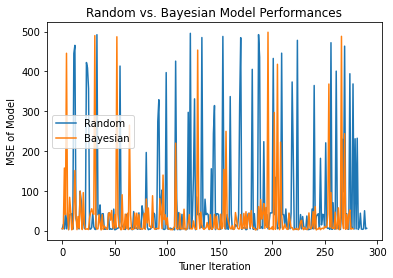

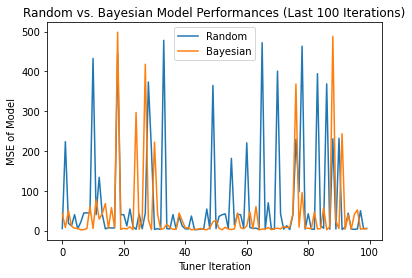

Random Mean: 71.0127686589854
Bayesian Mean: 38.1747105138765
Best Random Search Model Performance: 1.891814112663269
Best Bayes Search Model Performance: 1.7246897220611572


In [ ]:
# Test performance of Random Search and Bayesian Search
random_performance, bayesian_performance = performance_suite.compare_random_bayesian(300, 50)

# Print all of training between Random and Bayes
plt.clf()
plt.plot([x[1] for x in random_performance], label='Random')
plt.plot([x[1] for x in bayesian_performance], label='Bayesian')
plt.title('Random vs. Bayesian Model Performances')
plt.xlabel('Tuner Iteration')
plt.ylabel('MSE of Model')
plt.legend()
plt.show()

# Print only end of training between the two algorithms
plt.clf()
plt.plot([x[1] for x in random_performance[-100:]], label='Random')
plt.plot([x[1] for x in bayesian_performance[-100:]], label='Bayesian')
plt.title('Random vs. Bayesian Model Performances (Last 100 Iterations)')
plt.xlabel('Tuner Iteration')
plt.ylabel('MSE of Model')
plt.legend()
plt.show()

# Print random and bayesian means
print(f'Random Mean: {np.mean([x[1] for x in random_performance])}')
print(f'Bayesian Mean: {np.mean([x[1] for x in bayesian_performance])}')

# Print best model perfomances from both algorithms
print(f'Best Random Search Model Performance: {min([x[1] for x in random_performance])}')
print(f'Best Bayes Search Model Performance: {min([x[1] for x in bayesian_performance])}')